# Proyecto 2: Análisis Exploratorio
**Facultad de Ingeniería** – CC3084 Data Science (Semestre II, 2025)

**Tema: Procesamiento de Lenguaje Natural**

**Reto seleccionado:** Jigsaw – Agile Community Rules Classification

**Fuente**: Kaggle Competition (2025)

**Integrantes:**

- Derek Fabian Arreaga Kelson | 22537
- Mónica Alejandra Salvatierra Chacón | 22249
- Sofía Mishell Velásquez Mérida | 22049
- Paula Rebeca Barillas Alvarez | 22764
## Librerías principales para análisis de datos y visualización

In [17]:
# Librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para texto
import re
import string
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter

# Configuración estética
plt.style.use('seaborn-v0_8')
sns.set_palette("coolwarm")
pd.set_option('display.max_colwidth', 200)

## 0. Cargar los datos

In [4]:
# Cargar datasets
DATA_PATH = "data/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
sample = pd.read_csv(DATA_PATH + "sample_submission.csv")

# Mostrar dimensiones
print("Tamaño del dataset de entrenamiento:", train.shape)
print("Tamaño del dataset de prueba:", test.shape)
print("Tamaño del archivo de submission:", sample.shape)

# Vista general
print("Columnas del dataset de entrenamiento:", list(train.columns))
train.head()

print("\nColumnas únicas en train:", set(train.columns) - set(test.columns))
print("Columnas únicas en test:", set(test.columns) - set(train.columns))



Tamaño del dataset de entrenamiento: (2029, 9)
Tamaño del dataset de prueba: (10, 8)
Tamaño del archivo de submission: (10, 2)
Columnas del dataset de entrenamiento: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation']

Columnas únicas en train: {'rule_violation'}
Columnas únicas en test: set()


El dataset de entrenamiento contiene 2029 comentarios con información asociada a reglas, subreddits y ejemplos positivos/negativos. La variable objetivo es `rule_violation`, una etiqueta binaria que indica si el comentario incumple la norma correspondiente. El dataset de prueba contiene los mismos atributos excepto la etiqueta objetivo, siguiendo el formato del archivo `sample_submission`.

## 1. Descripción general del conjunto de datos

El dataset **Jigsaw – Agile Community Rules Classification** contiene comentarios de Reddit etiquetados según si violan o no las reglas de cada subreddit.  
Cada fila representa un comentario con su texto (`body`), la regla asociada (`rule`), el subreddit de origen (`subreddit`), ejemplos positivos y negativos, y la etiqueta binaria `rule_violation`.

In [3]:
# Tipos de datos y valores faltantes
train.info()

# Resumen estadístico general
train.describe(include='all').T

# Conteo de valores nulos
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  2029 non-null   object
 6   negative_example_1  2029 non-null   object
 7   negative_example_2  2029 non-null   object
 8   rule_violation      2029 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 142.8+ KB


row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64

### 1a. Distribución de tipos de datos

In [5]:
train.dtypes.value_counts()


object    7
int64     2
Name: count, dtype: int64

### 1b. Longitud del texto del comentario

In [6]:
train['body_length'] = train['body'].apply(lambda x: len(str(x)))
train['body_length'].describe()


count    2029.000000
mean      177.979300
std       114.436612
min        51.000000
25%        88.000000
50%       138.000000
75%       239.000000
max       515.000000
Name: body_length, dtype: float64

**Interpretación:**
- El conjunto de entrenamiento contiene **2029 observaciones** y **9 columnas**.  
- No se identifican valores nulos; todos los campos están completos. Esto simplifica el preprocesamiento, ya que no es necesario imputar ni descartar filas.  
- Las variables son mayormente de tipo `object` (texto) y `int` (etiqueta binaria).
- El dataset de prueba cuenta con 10 observaciones y 8 columnas, mientras que el archivo `sample_submission.csv` tiene 10 filas con el formato de envío requerido.
- El análisis de la longitud del comentario (`body_length`) muestra que los textos tienen una extensión promedio de 178 caracteres, con una variabilidad moderada. El mínimo es de 51 caracteres y el máximo de 515, lo que indica que los comentarios son relativamente cortos, pero con suficiente contenido textual para extraer patrones léxicos relevantes.

El dataset es compacto, limpio y adecuado para comenzar un análisis exploratorio centrado en patrones de texto y relaciones entre las reglas, los subreddits y las violaciones detectadas.

------
## 2. Distribución de la variable objetivo (`rule_violation`)

Esta variable indica si un comentario violó (`1`) o no (`0`) una regla del subreddit.  
El objetivo principal es analizar la proporción de casos positivos y negativos.


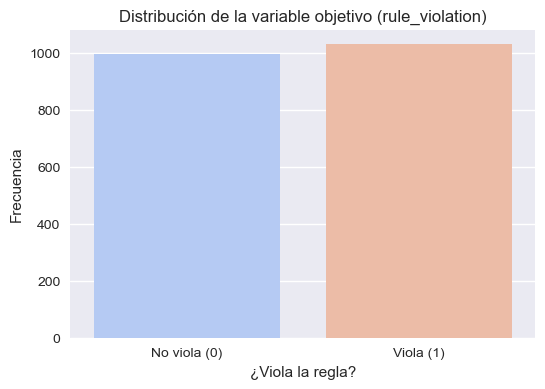

rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='rule_violation', data=train, palette='coolwarm')
plt.title("Distribución de la variable objetivo (rule_violation)")
plt.xticks([0, 1], ["No viola (0)", "Viola (1)"])
plt.xlabel("¿Viola la regla?")
plt.ylabel("Frecuencia")
plt.show()

train['rule_violation'].value_counts(normalize=True)

- La proporción es **casi balanceada**: aproximadamente 50.8% violan una regla y 49.1% no lo hacen.  
- Esto es positivo para el modelado posterior, ya que evita sesgos hacia una sola clase.

La distribución casi uniforme de la variable objetivo indica que el conjunto está balanceado, lo cual es favorable para el entrenamiento de modelos de clasificación binaria. Al no existir una clase dominante, no es necesario aplicar técnicas adicionales de balanceo como oversampling o undersampling en esta etapa.

---
## 3. Subreddits más frecuentes

El gráfico de barras muestra los **15 subreddits con mayor número de comentarios** en el dataset.



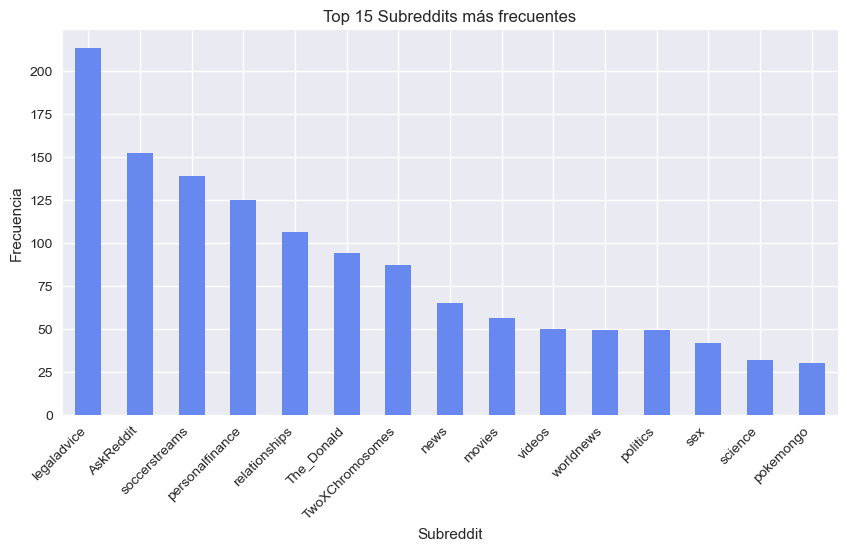

In [8]:
# Recuento de subreddits
plt.figure(figsize=(10,5))
train['subreddit'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Subreddits más frecuentes")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Subreddit")
plt.ylabel("Frecuencia")
plt.show()


- Los subreddits más representativos son **r/legaladvice**, **r/AskReddit**, y **r/soccerstreams**.  
- La mayor concentración de datos proviene de **r/legaladvice**, con más de 200 comentarios, seguido de foros de discusión general o entretenimiento.  
- Esto sugiere que los temas legales y las solicitudes de consejo son especialmente relevantes en la detección de violaciones.

Existe una concentración temática en comunidades donde las normas son estrictas (por ejemplo, prohibición de asesoría legal o autopromoción), lo cual influirá en los patrones lingüísticos del modelo. 

Los subreddits con mayor volumen suelen tener normas más estrictas o mayor actividad de moderación, lo cual puede aumentar la probabilidad de encontrar casos positivos (`rule_violation`). Esto puede influir en la distribución de patrones lingüísticos del modelo.

Además, la concentración de ejemplos en ciertos subreddits implica que el modelo podría aprender patrones específicos de esas comunidades y generalizar menos hacia subreddits con baja representación. Esto deberá considerarse en la etapa de modelado.

---

## 4. Reglas más comunes

El gráfico representa las **reglas más citadas en los comentarios analizados**.


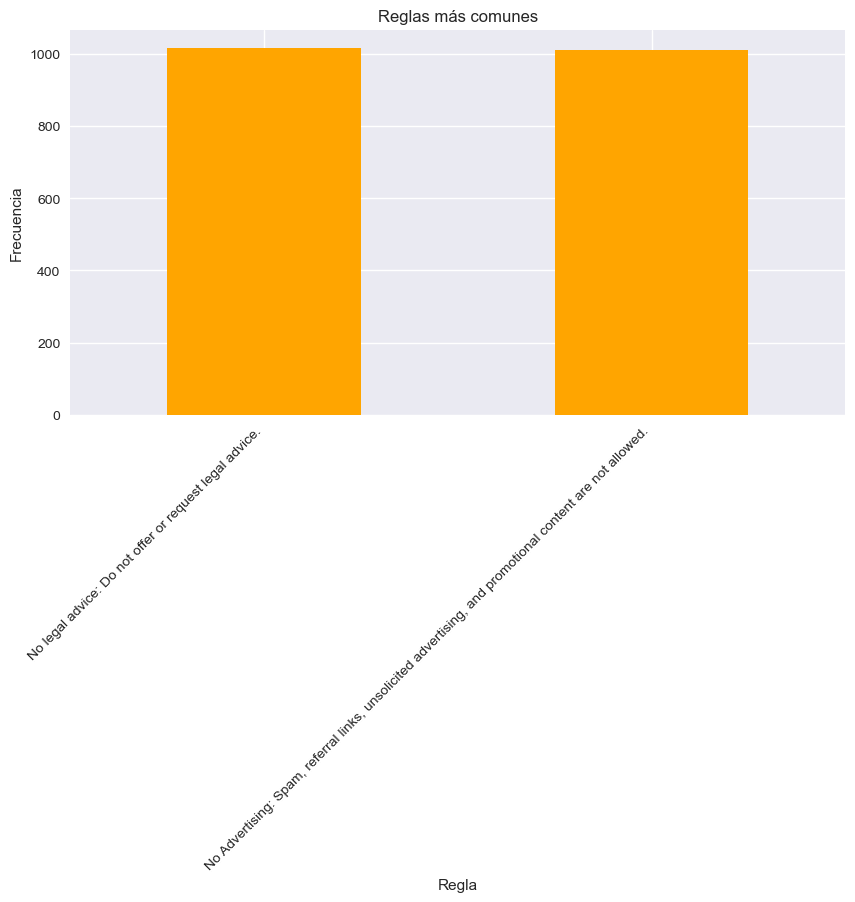

In [10]:
# Recuento de reglas
plt.figure(figsize=(10,5))
train['rule'].value_counts().head(15).plot(kind='bar', color='orange')
plt.title("Reglas más comunes")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Regla")
plt.ylabel("Frecuencia")
plt.show()

- Se destacan principalmente dos reglas:
  1. *“No legal advice: Do not offer or request legal advice.”* (no pedir ni dar asesoría legal)
  2. *“No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.”* (prohibición de spam, enlaces de referidos y contenido promocional)
- La frecuencia similar entre ambas reglas indica que el conjunto está equilibrado también a nivel de categorías normativas.

El modelo deberá distinguir entre **violaciones por asesoría legal** y **publicidad o spam**, categorías con contextos y vocabularios muy distintos. Esto sugiere la necesidad de enfoques de PLN sensibles al contexto. Las diferencias entre solicitudes legales y contenido publicitario requerirán representaciones contextuales sólidas, lo cual puede influir en la elección del modelo (por ejemplo, modelos basados en embeddings o transformers).

La baja variedad de reglas implica que el problema no es multiclase sino binario, lo que reduce la complejidad del modelo pero aumenta la importancia de identificar matices lingüísticos entre dos tipos de violaciones muy distintas.

---

## 5. Distribución de longitud de los comentarios

El boxplot compara la longitud (en número de palabras) entre comentarios que violan o no las reglas.



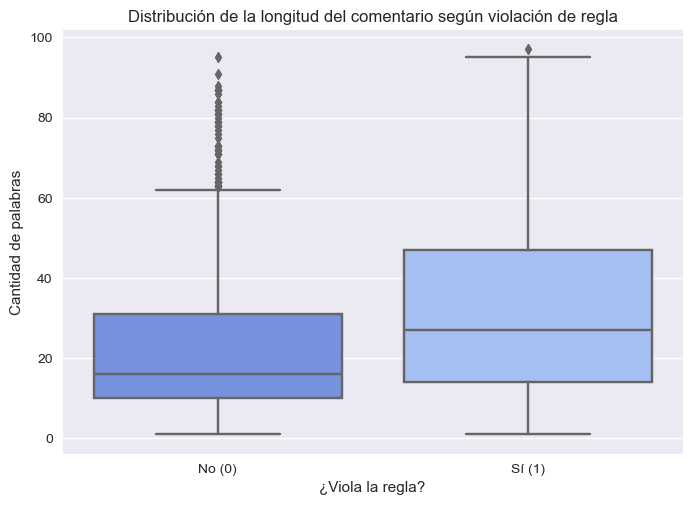

comment_length                                               \
                        count       mean        std  min   25%   50%   75%   
rule_violation                                                               
0                       998.0  23.134269  18.667550  1.0  10.0  16.0  31.0   
1                      1031.0  32.637245  22.487026  1.0  14.0  27.0  47.0   

                      
                 max  
rule_violation        
0               95.0  
1               97.0

In [12]:
train['comment_length'] = train['body'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='rule_violation', y='comment_length', data=train)
plt.title("Distribución de la longitud del comentario según violación de regla")
plt.xticks([0, 1], ["No (0)", "Sí (1)"])
plt.xlabel("¿Viola la regla?")
plt.ylabel("Cantidad de palabras")
plt.show()

train[['comment_length', 'rule_violation']].groupby('rule_violation').describe()

- Los comentarios que **violan reglas** son en promedio **más largos (≈33 palabras)** que los que no lo hacen (≈23 palabras).  
- Existe mayor dispersión y presencia de outliers en los comentarios no violatorios, lo que sugiere diversidad en estilos y extensiones.

La longitud del comentario muestra una diferencia clara entre clases, aunque la superposición y la variabilidad sugieren que es un **predictor con poder limitado** por sí solo, pero potencialmente útil en combinación con representaciones textuales más ricas.

---




## Limpieza y preprocesamiento de texto

In [13]:
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # eliminar URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # eliminar puntuación
    text = re.sub(r'\s+', ' ', text).strip()  # espacios múltiples
    return text

train['clean_body'] = train['body'].apply(limpiar_texto)

La función de limpieza estandariza los comentarios para su posterior análisis. Primero convierte todo a minúsculas para evitar diferencias artificiales entre palabras. Luego elimina enlaces, lo cual es útil porque los URL no aportan significado léxico relevante. Después elimina la puntuación y reduce los espacios múltiples para obtener texto más uniforme. El resultado final es una versión simplificada del comentario original.

## 6. Nube de palabras – Comentarios que violan reglas
La nube de palabras visualiza los términos más frecuentes en los comentarios etiquetados como violatorios.

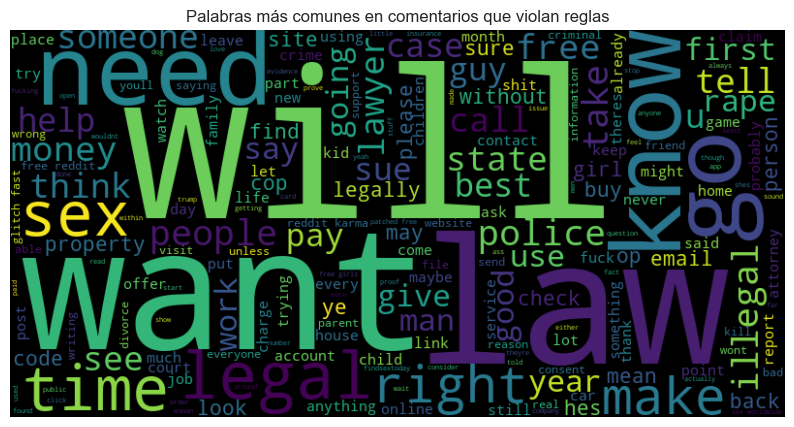

In [31]:
violaciones = ' '.join(train[train['rule_violation']==1]['clean_body'])
no_violaciones = ' '.join(train[train['rule_violation']==0]['clean_body'])

custom_stopwords = STOPWORDS.union({
    "im", "dont", "youre", "cant", "ive", "id", "ill",
    "thats", "didnt", "doesnt", "isnt", "arent", "wasnt",
    "one", "two", "also", "even", "way", "now", "well", 
    "get", "got", "really", "thing", "things"
})

# Nube de palabras para comentarios que violan reglas
plt.figure(figsize=(10,6))

wc = WordCloud(
    width=800,
    height=400,
    background_color='black',
    stopwords=custom_stopwords
).generate(violaciones)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras más comunes en comentarios que violan reglas")
plt.show()

La nube de palabras depurada revela términos altamente representativos de los comentarios que violan reglas. Sobresalen palabras como **“law”, “legal”, “police”, “case”, “state” y “right”**, que reflejan la presencia de consultas legales directas o discusiones jurídicas, prohibidas en comunidades como r/legaladvice.

También destacan verbos como **“need”, “want”, “help” y “know”**, asociados a solicitudes de orientación, peticiones de consejo o intentos de obtener instrucciones explícitas sobre cómo proceder en situaciones legales. La prominencia de **“will”** es especialmente relevante, ya que en este contexto alude a testamentos y herencias, un tema recurrente en conflictos legales personales.

El vocabulario muestra que las violaciones provienen principalmente de usuarios que buscan asesoría legal sobre disputas familiares, herencias, propiedad o procedimientos judiciales, lo cual coincide con el comportamiento típico observado en subreddits con normas estrictas sobre la prohibición de brindar asesoría profesional.


---

## 7. Nube de palabras – Comentarios que no violan reglas

La segunda nube de palabras muestra las palabras predominantes en comentarios **que no violan reglas**.


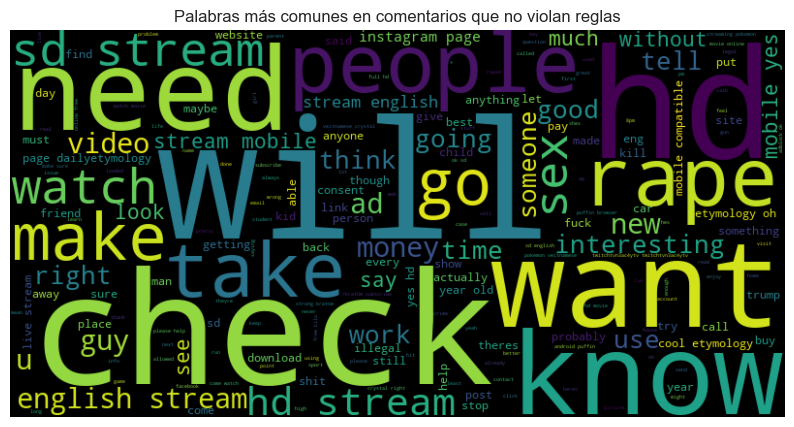

In [29]:
violaciones = ' '.join(train[train['rule_violation']==1]['clean_body'])
no_violaciones = ' '.join(train[train['rule_violation']==0]['clean_body'])

# Nube de palabras para comentarios que no violan reglas
plt.figure(figsize=(10,6))

wc = WordCloud(
    width=800,
    height=400,
    background_color='black',
    stopwords=custom_stopwords
).generate(no_violaciones)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras más comunes en comentarios que no violan reglas")
plt.show()

A diferencia de los comentarios infractores, aquí predominan palabras relacionadas con actividades cotidianas, tecnología y contenido multimedia, como **“check”, “video”, “stream”, “watch”, “mobile”**. Estos términos reflejan que los usuarios suelen pedir recomendaciones, verificar información o discutir temas de entretenimiento o uso de dispositivos. Además, aparecen expresiones como **“think”, “look”, “interesting”**, que reflejan un tono más reflexivo y menos directivo.

Aunque también se observan palabras que podrían aparecer en otros contextos **(“rape”, “sex”, “illegal”)**, estas no se presentan con un peso semántico claramente imperativo. Más bien, parecen surgir en discusiones informativas o descriptivas y no como solicitudes de asesoría legal, lo cual distingue a esta clase de la nube correspondiente a los comentarios violatorios.

Los comentarios que no violan reglas tienden a usar un **lenguaje más descriptivo y neutral**, con un estilo más cercano a la conversación cotidiana o a la consulta informal. Esto puede ayudar a los modelos supervisados a construir representaciones textuales que diferencien entre peticiones directas que buscan asesoría legal y discusiones más amplias sin intención de infringir normas del subreddit.

---

## 8. Relación entre Subreddit y Violación de Reglas
El gráfico apilado muestra cómo se distribuyen los comentarios violatorios y no violatorios por subreddit.


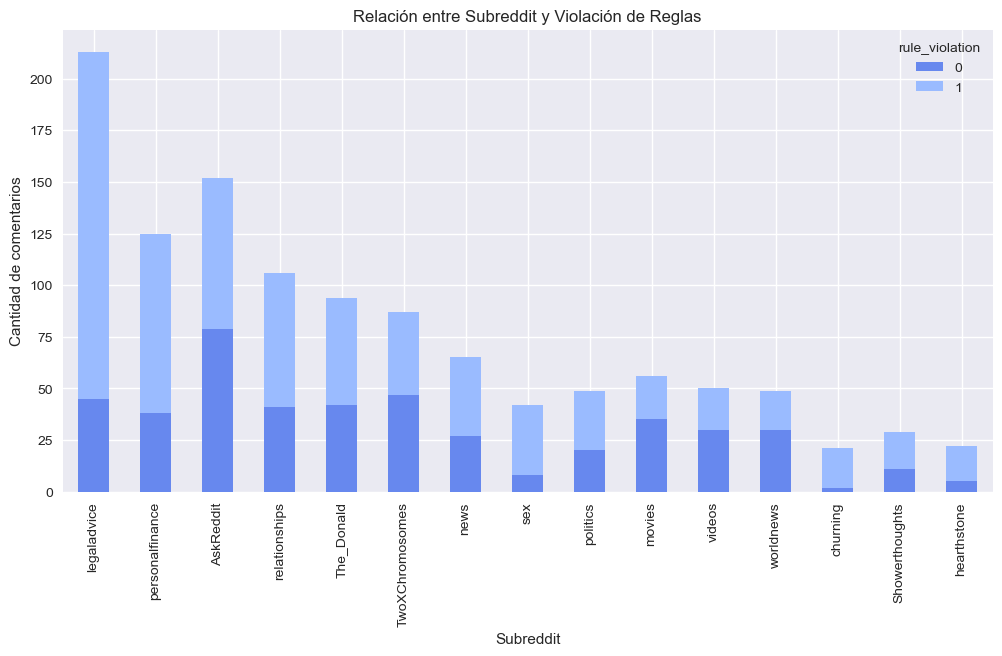

In [33]:
pivot = pd.crosstab(train['subreddit'], train['rule_violation'])
pivot = pivot.sort_values(by=1, ascending=False).head(15)

pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Relación entre Subreddit y Violación de Reglas")
plt.xlabel("Subreddit")
plt.ylabel("Cantidad de comentarios")
plt.show()

- En **r/legaladvice** predominan los comentarios que **violan reglas**, lo que es coherente con su prohibición explícita de brindar asesoría legal.  
- Subreddits como **r/AskReddit** o **r/personalfinance** presentan distribuciones más equilibradas.  
- Comunidades como **r/movies** o **r/videos** registran menos violaciones.

El contexto del subreddit es una **variable altamente informativa**. Algunos foros tienen una propensión natural a las infracciones por la temática que tratan.

---

# 9. Correlación entre longitud del comentario y violación de reglas
El mapa de calor representa la correlación entre `comment_length` y `rule_violation`.

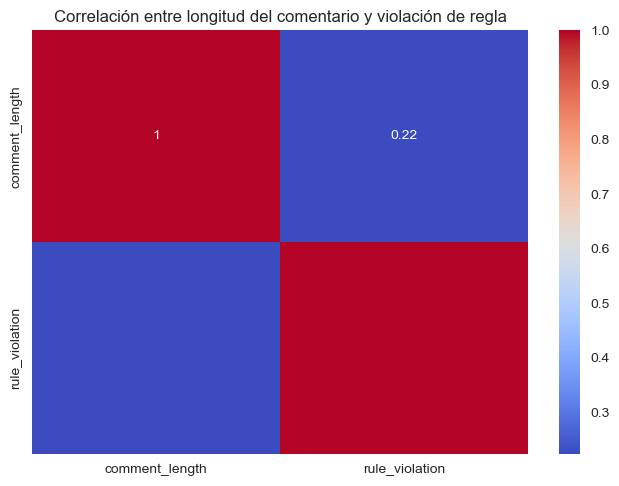

In [34]:
corr = train[['comment_length', 'rule_violation']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlación entre longitud del comentario y violación de regla")
plt.show()

- La correlación es **positiva pero débil (≈0.22)**, Esto significa que, aunque los comentarios más extensos tienen una ligera tendencia a violar reglas, la relación no es suficientemente fuerte como para considerar la longitud como un predictor determinante por sí sola.

La magnitud reducida del coeficiente sugiere que la infracción de reglas **no depende directamente del tamaño del comentario**, sino que probablemente está ligada al contenido semántico, al tono y a las intenciones comunicativas del texto.

---

# 10. Resumen general de hallazgos
1. El dataset está limpio y sin valores nulos, con una distribución moderadamente balanceada entre comentarios violatorios y no violatorios.

2. La mayoría de infracciones provienen de subreddits con normas temáticas estrictas, como r/legaladvice o r/personalfinance.

3. Los comentarios que violan reglas tienden a ser más extensos y a emplear un lenguaje más directo, consultivo o urgente.

4. Los términos frecuentes en los comentarios infractores (“law”, “illegal”, “help”, “need”) reflejan que muchos textos buscan asesoría o discuten situaciones legales.

5. La correlación entre longitud del comentario y violación de reglas es baja pero presente, lo que indica que la longitud es un atributo auxiliar más que un predictor principal.

**Conclusión final:**  

El análisis exploratorio permitió identificar patrones relevantes en la estructura y el contenido de los comentarios. El dataset está limpio y moderadamente balanceado, y muestra diferencias claras en longitud, tono y temática entre comentarios violatorios y no violatorios. Además, dado que el conjunto de prueba incluye reglas no presentes en el entrenamiento, el modelo debe enfocarse en aprender patrones lingüísticos generales de infracción y no depender de reglas específicas.

Los siguientes pasos incluyen limpieza avanzada, vectorización textual (TF-IDF o embeddings) y entrenamiento de modelos supervisados capaces de generalizar a reglas nuevas y contextos variados.